In [35]:
import pandas as pd
import geopandas as gpd
import os
import osmnx as ox
import matplotlib.pyplot as plt
import contextily as ctx


#Define The Study area
mahallatPop = gpd.read_file("data/data/tehran_popblocks_95.shp")
area = ox.geocode_to_gdf("Tehran, Iran")

In [36]:
#Get the Supply Data
#You can find the tags you need here https://wiki.openstreetmap.org/wiki/Map_features
place = 'Tehran, Iran'

tag_amenity = {'amenity': ['school','hospital','cafe','restaurant']}
amenities = ox.features_from_place(place, tag_amenity)
#amenities['amenity'].value_counts()



In [37]:
tag_leisure = {'leisure': ['park']}
leisure = ox.features_from_place(place, tag_leisure)
leisure['leisure'].value_counts()
facilities = gpd.GeoDataFrame(pd.concat([amenities,leisure], ignore_index=True))
#facilities.sample(10)
facilities.geom_type.value_counts()

Polygon         4205
Point           3074
MultiPolygon       3
Name: count, dtype: int64

In [38]:
#Points (supply)
point = facilities[facilities.geom_type == 'Point']
point['s_j'] = 1
#point[['amenity','s_j','geometry']].sample(10)

f:\Data analytics\genv\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [39]:
#Polygons (supply)
all_gdfs = []
service = [tag_amenity, tag_leisure]
for i in service:
    service_gdf = ox.features_from_place(place,i)
    service_gdf = service_gdf.to_crs(epsg=32639)
    print(i)
    print(service_gdf.geom_type.value_counts())
    service_gdf['s_j'] = service_gdf.apply(
        lambda row: row.geometry.area if row.geometry.geom_type in ['Polygon','MultiPolygon'] else 1,
        axis=1
    )
    
    all_gdfs.append(service_gdf)


supply = pd.concat(all_gdfs, ignore_index=True)
supply = gpd.GeoDataFrame(supply, geometry='geometry', crs='epsg:32639')

#service_gdf.sample(10)
len(supply)
type(supply)
#supply[['amenity','leisure','s_j']].sample(10)

{'amenity': ['school', 'hospital', 'cafe', 'restaurant']}
Point      3054
Polygon    1615
Name: count, dtype: int64
{'leisure': ['park']}
Polygon         2590
Point             20
MultiPolygon       3
Name: count, dtype: int64


geopandas.geodataframe.GeoDataFrame

In [40]:
#Yousef Abad Pop (Demand)
mahallatPop['NAME_MAHAL'].unique()
yousefAbadPop = mahallatPop[mahallatPop['NAME_MAHAL'] == 'يوسف اباد']
yousefAbadPop.geom_type.value_counts()
demand = yousefAbadPop
demand = demand.to_crs(epsg=32639)
demand.geom_type.value_counts()


Polygon    172
Name: count, dtype: int64

In [41]:
#Calculating the supply-to-demand ratio (Rj)
supply = supply.to_crs(epsg=32639)
demand = demand.to_crs(epsg=32639)
radius = 1500

supply['R_j'] = 0.0
supply['demand_pop'] = 0

for idx, sup in supply.iterrows():
    nearby_demand = demand[demand.geometry.distance(sup.geometry) <= radius]
    population = nearby_demand['POPULATION'].sum()
    supply.at[idx, 'demand_pop'] = population

    if population > 0:
        supply['R_j'] = supply['s_j'] / population
    else:
        supply['R_j'] = 0

#supply.sample(10)

In [42]:
print(demand.geom_type.unique())
demand.head()
demand = demand.to_crs(supply.crs)
supply.crs

['Polygon']


<Projected CRS: EPSG:32639>
Name: WGS 84 / UTM zone 39N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 48°E and 54°E, northern hemisphere between equator and 84°N, onshore and offshore. Azerbaijan. Bahrain. Islamic Republic of Iran. Iraq. Kazakhstan. Kuwait. Oman. Qatar. Russian Federation. Saudi Arabia. Somalia. Turkmenistan. United Arab Emirates. Yemen.
- bounds: (48.0, 0.0, 54.0, 84.0)
Coordinate Operation:
- name: UTM zone 39N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [43]:
#Checking if the demand and supply are actually overlap
import matplotlib.pyplot as plt
demand_points = demand.copy()
demand_points['geometry'] = demand_points.centroid
# Points
points = supply[supply.geom_type == 'Point']
# Polygons
polygons = supply[supply.geom_type.isin(['Polygon','MultiPolygon'])]


# fig, ax = plt.subplots(figsize=(10,10))
# demand_points.plot(ax=ax, color='red', edgecolor='none', alpha=0.5 , markersize=20 , label='Demand', zorder = 1)
# polygons.plot(ax=ax, color='green', alpha=0.5, edgecolor='black', label='Polygons' , zorder= 2)
# points.plot(ax=ax, color='blue', alpha=0.7, markersize=20, label='Points', zorder = 3)
# print(len(demand))
# plt.title('2SFCA accessibility')
# plt.legend()
# plt.show()

In [44]:
print(supply.geom_type.unique())
print(demand.geom_type.unique())
print(supply.crs, demand.crs)

['Point' 'Polygon' 'MultiPolygon']
['Polygon']
epsg:32639 EPSG:32639


In [45]:
#Calculating the accebility at each demand point
demand['A_i'] = 0.0

for idx, dem in demand.iterrows():
    nearby_supply = supply[supply.geometry.distance(dem.geometry) <= 1500 ]
    nearby_supply['R_j']
    demand.at[idx, 'A_i'] = nearby_supply['R_j'].sum()

#demand.sample(10)

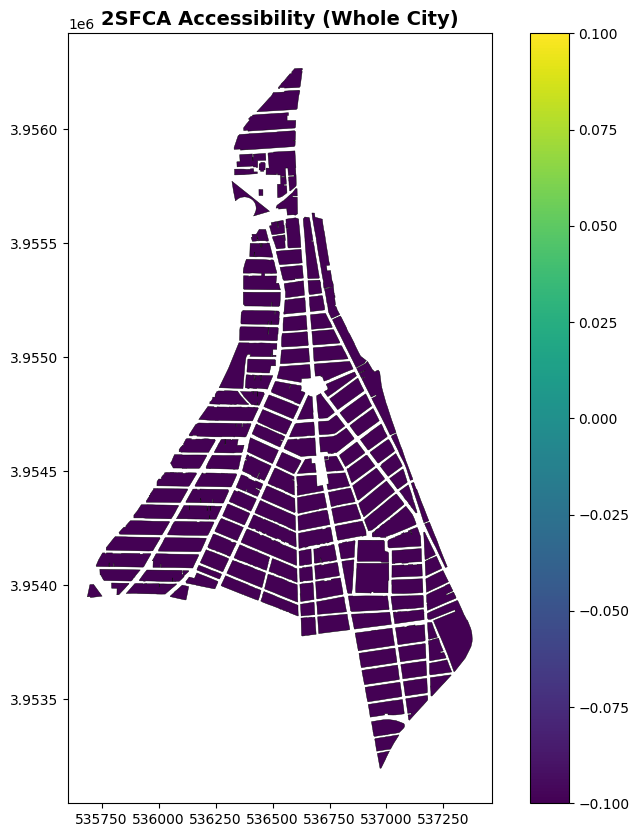

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))
demand.plot(column='A_i', cmap='viridis', legend=True, edgecolor='black', linewidth=0.3, ax=ax)
plt.title('2SFCA Accessibility YousefAbad', fontsize=14, fontweight='bold')
plt.show()